# How Competitive are Health Insurance Marketplaces?

## By Laura Gascue

Since 2014, with the Affordable Care Act (ACA), individuals without access to health care insurance through employment, can purchase in the Health Insurance Marketplace. The system was created to define a set of minimum coverage standards at affordable cost, aiming to widely expand access to health insurance. The mechanism to achieve this relies on a set of regulations placed on insurers and on market competition. The question we explore here is, are these markets competitive?

In this notes we limit the analysis to the observed final result: how many options an individual faces when choosing health insurance in the Insurance Exchange Marketplace, where plans offer certain guarantees in terms of coverage and premiums. 

We take a look at all health insurance plans being offered in the US in 2018 through the federally facilitated market place. There are 39 states under the federal program. An individual will have access to the plans offered in the area they live (offered in their county). We compute the number of plans being offered in each FIPS county code area on those states and use it as a measure of the level of competition in that market. Further, we look at the distribution of the number of plans offered, and explore correlations with geographic area characteristics. Relevant factors to consider in explaining these measures are state, population size, unemployment level, number of health professionals or health facilities available in the area, population age and population income, among other variables.

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

In [3]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

## Federally Facilitated Marketplace Plans in 2018 by FIPS

### The Data
The file plans_ahrf has summary information on plans offered under the ACA individual isurance markets. It only includes federally mandated markets. The file includes for each county (CBSA or FIPS) the following measures:
* Premium_30, count - count of different plans offered,
* Issuer_ID, nunique - number of different insurance companies offereing plans,
* Premium_XX, mean - average perimium for multiple age groups
* Pop2017 - County population in 2017 (from AHRF)
* MedIncome2017 - County median income in 2017 (from AHRF)
* IndMarketEnroll2017 - Number of individuals enrolled in a health insurance plan though the individual marketplace in 2017 (from AHRF)
* Unemployment - County unemployment rate (from AHRF)

Other variables include:
* fips_st - Fips state code
* fips_county - Fips_county

Data sources:

(1) 2018 QHP landscape data downloaded from https://www.healthcare.gov/health-plan-information-2018/

(2) Area resource health file downloaded from https://data.hrsa.gov/data/download


In [4]:
plans_ahrf = (pd.read_json("./plans_data.json"))

In [5]:
print("TABLE 1 - Selected Measures")
print(plans_ahrf[['fips','count_plans','count_issuers','CBSA_Ind','Num_Hosp2017', 
                 'Pop2017', 'MedIncome2017','IndMarketEnroll2017','Unemployment']].describe())

TABLE 1 - Selected Measures
               fips  count_plans  count_issuers     CBSA_Ind  Num_Hosp2017  \
count   2718.000000  2718.000000    2718.000000  2718.000000   2718.000000   
mean   31341.718543    14.461737       1.710817     0.784032      1.804268   
std    14959.243238    10.564618       1.004719     0.769837      3.653862   
min     1001.000000     2.000000       1.000000     0.000000      0.000000   
25%    19135.500000     7.000000       1.000000     0.000000      1.000000   
50%    31014.000000    12.000000       1.000000     1.000000      1.000000   
75%    46092.500000    18.000000       2.000000     1.000000      2.000000   
max    56045.000000   119.000000       7.000000     2.000000     75.000000   

            Pop2017  MedIncome2017  IndMarketEnroll2017  Unemployment  
count  2.718000e+03    2718.000000          2718.000000   2718.000000  
mean   8.356875e+04   49715.470935          3385.483076      4.637013  
std    2.429608e+05   12603.786716         13420.4737

### The Market
The analysis is limited to the states running under the federal government in 2018, and the set of qualified health plans (QHP) offered. Some states, like California with Covered California, chose to run their own Marketplace. The original file has 39,348 rows and a large number of columns. We only read in a subset of columns, containing plan identification variables, plan type, geographic area where offered (at the FIPS County Code Level), and plan premiums, a total of 26 columns. The database cover 39 states: AK, AL, FL, AR, AZ, DE, GA, IL, MI, HI, MO, IA, IN, MS, KS, KY, LA, ME, MT, PA, ND, NJ, NE, NM, NH, NC, OR, WI, NV, OH, OK, SD, SC, VA, TX, TN, UT, WV, WY. The number of total distinct plans offered is 2,722.

Depending on the generosity of the plan it will belong to one of the potentially many tiers available (the main ones being bronze, silver, and gold). Since one inssurer may offered more than one plan, we also caclulate the number of issurers in each county as a second measure of competition. 

## Plan Options Distribution

The number of plans offered accros all counties participating in the federally mandated markets ranges from 2 to 119, with an average number of 14 plans, and a median of 12 plans. The distribution is concentrated on the left of the curve with an interquartile range of 11. Half of the counties offered a number of plans between 7 and 18. In order to factor the size of each geographic area, and reflect the options faced by all individuals in those areas we use the 2017 enrollment in these markets to evaluate this distribution. Fig 1 shows the distribution of the number of options faced by individuals in this market.

However, many of these plans target different individuals and they may be offered by the same insurance company (issurer) applying market segmentation. Taking this into account, we can look at the number of issuers participating in each area. The options now are highly reduced. The number of issuers range from 1 to 7, with 75% of the areas having one or two participants. Fig 2 shows the distribution of number of issuer optons faced by individuals in this market.

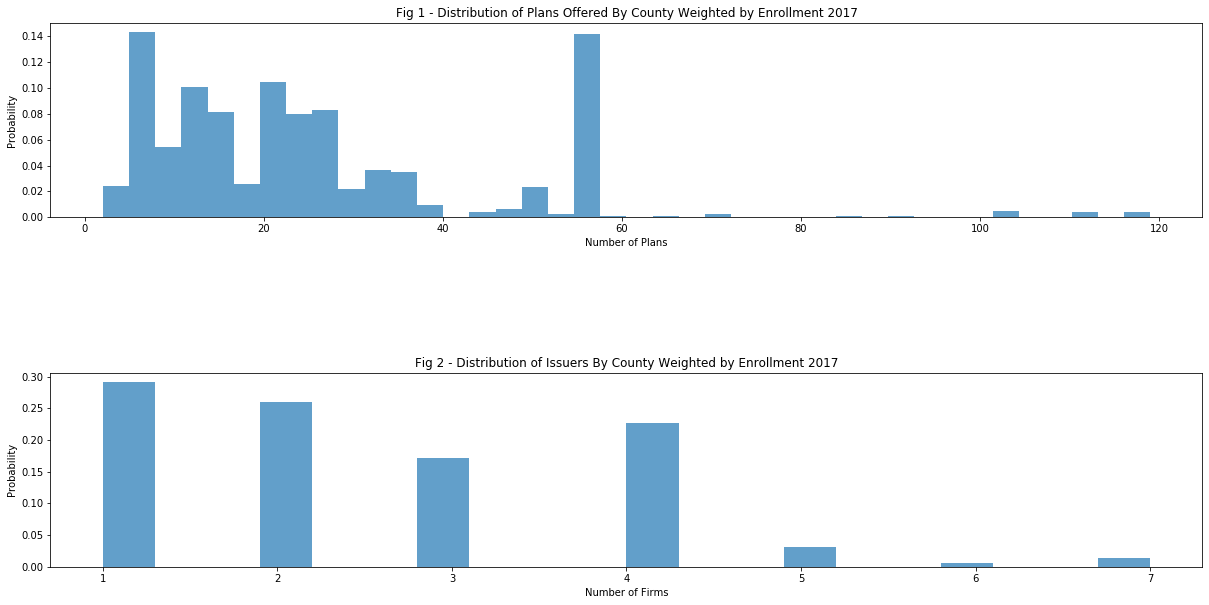

In [6]:
# How many plans/issuers individuals face?
# we use last year's market size to weight number of plans per FIP codes.
# change to seaborn
plt.figure(figsize=(20,10))
wgt = plans_ahrf['IndMarketEnroll2017']/np.sum(plans_ahrf['IndMarketEnroll2017'])

plt.subplot(211)
plt.hist(plans_ahrf['count_plans'],bins=40, weights=wgt, alpha=0.7)
plt.title("Fig 1 - Distribution of Plans Offered By County Weighted by Enrollment 2017")
plt.xlabel("Number of Plans")
plt.ylabel("Probability")

plt.subplot(212)
plt.hist(plans_ahrf['count_issuers'], bins=20, weights=wgt, alpha=0.7)
plt.title("Fig 2 - Distribution of Issuers By County Weighted by Enrollment 2017")
plt.xlabel("Number of Firms")
plt.ylabel("Probability")

plt.subplots_adjust(left=0.1, right=0.9 ,hspace=0.8)
plt.savefig("Data description-figure 1_2.png")

## Dispersion Accross States and Other Correlations

The areas analyzied here are limited to states with Individual Market health insurance federally regulated. However, States behave different. The distribution of the number of plans available varies widely across states. Median number of plans offered by state ranges from 4 to 36. Among states offering larger options we see Florida and Wisconsin. In the lower end we see Alaska, Arizona, Mississippi and Iowa. This results suggests that even under federally mandated states, probably state regulations have an effect in these markets. See Fig. 3

An other aspect that helps identify areas with different options is population size. We group counties into Metropolitan Statistical Areas (area with one or more urban areaof 50,000 or more), Micropolitan Statistical Areas (areas with one urban cluster of 10,000 people but less than 50,000) and Non-Statistical Area, with no urban areas of 10,000 people or more. The distribution under the two lowest population categories categores show areas with similar health plan options and similar dispersion, while the areas with higher population present a tendency of more health plan options and higher variability. 

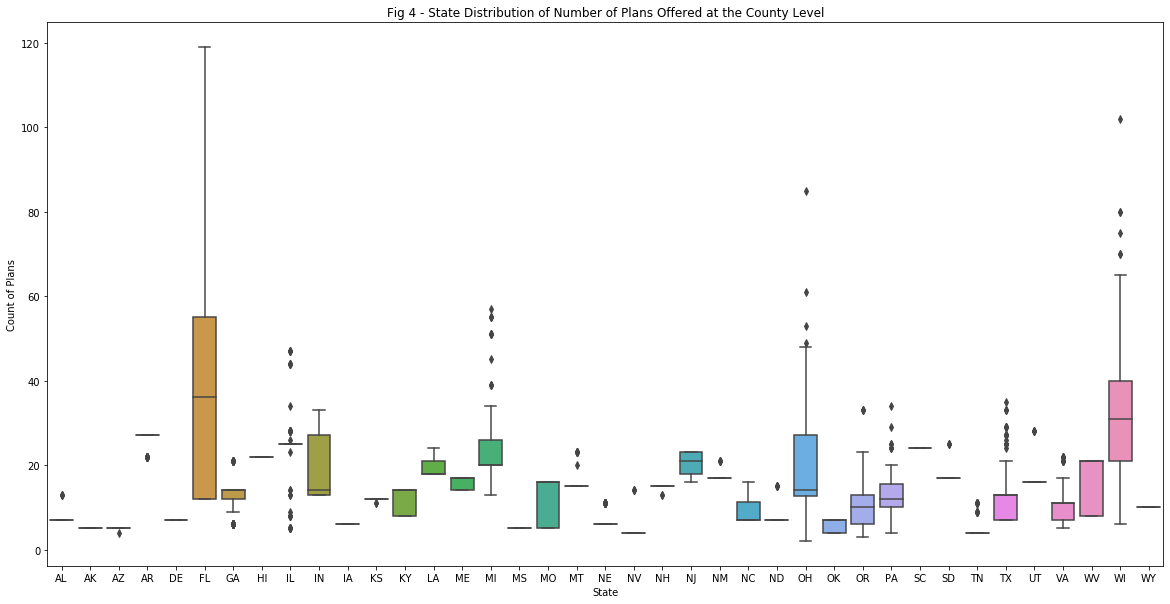

In [15]:
# how many plans offered on each State - Distribution
plt.figure(figsize=(20,10))
_ = sns.boxplot(x='st', y='count_plans', data=plans_ahrf) 
# may be sort by state population size or color by it. 
_ = plt.title("Fig 4 - State Distribution of Number of Plans Offered at the County Level")
_ = plt.ylabel("Count of Plans")
_ = plt.xlabel("State")
plt.savefig("Data description-figure 4.png")

In [8]:
state_medplans = plans_ahrf.groupby('st')['count_plans'].median()
print ("States with Lowest Median Number of Plans")
print(plans_ahrf.groupby('state')['count_plans'].max().sort_values().head(10))

States with Lowest Median Number of Plans
state
Alaska          5
Arizona         5
Mississippi     5
Iowa            6
Delaware        7
Oklahoma        7
Wyoming        10
Tennessee      11
Nebraska       11
Kansas         12
Name: count_plans, dtype: int64


In [9]:
plans_ahrf['CBSA_Type']=''
plans_ahrf.CBSA_Type[plans_ahrf.CBSA_Ind==0]='Not a Statistical Area'
plans_ahrf.CBSA_Type[plans_ahrf.CBSA_Ind==1]='Metropolitan Statistical Area'
plans_ahrf.CBSA_Type[plans_ahrf.CBSA_Ind==2]='Micropolitan Statistical Area'

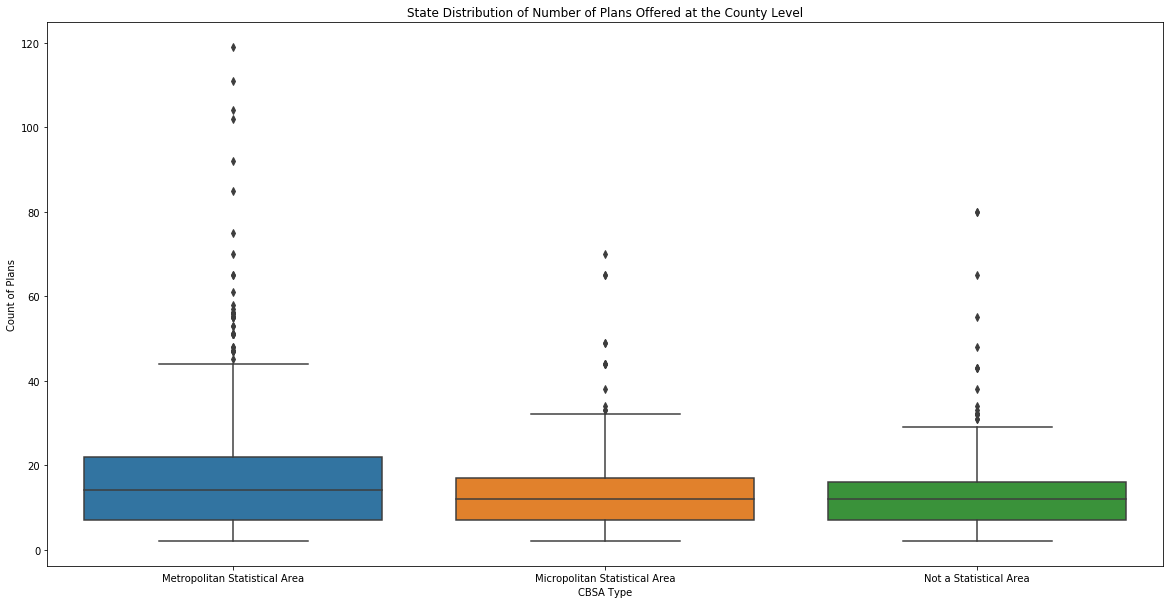

<Figure size 432x288 with 0 Axes>

In [10]:
# how many plans offered on each State - Distribution
plt.figure(figsize=(20,10))
_ = sns.boxplot(x='CBSA_Type', y='count_plans', data=plans_ahrf) 
# may be sort by state population size or color by it. 
_ = plt.title("State Distribution of Number of Plans Offered at the County Level")
_ = plt.ylabel("Count of Plans")
_ = plt.xlabel("CBSA Type")
plt.savefig("Data description - Boxplot by county type.png")

One could presume that as there are potentially more enrollees in an area, that market will be more attractive to health insurance companies. As companies negotiate with health providers in the area, a larger pull of patients can lead to lower costs. This make the market more attractive to insurers, with potentially higher profits. Population income level in the area can also play a role in the number of plans offered. Areas with higher income can support higher coverage, with higher premiums and potentially higher profits for insureres.

We look at scatter plots and correlations between the number of plans offered on each geographic area in 2018, and the total population in the area in 2017, the total enrollment in the Health Insurance Market in 2017, the unemployment rate. There seems to be a small positive correlation between the number of plans and market enrollment in the previous year (0.27), and the number of plans and population size (0.25). 

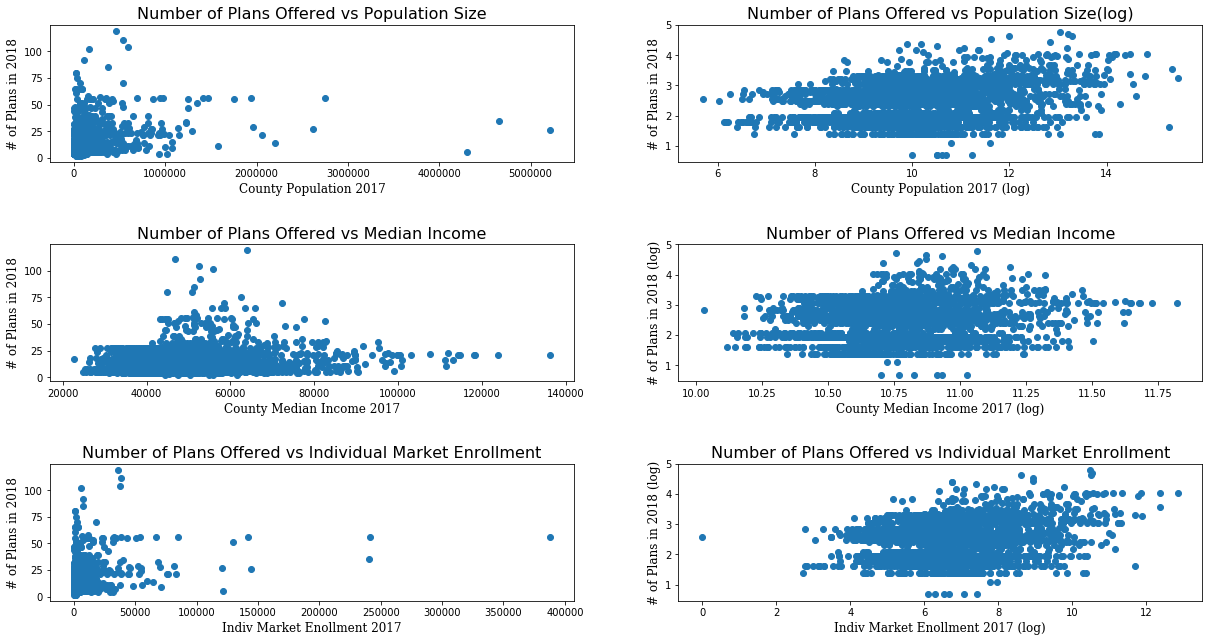

In [38]:
# Plot all continous features and target variable - 
plt.figure(figsize=(20,10))

plt.subplot(321)
_ = plt.scatter(x = plans_data['Pop2017'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("County Population 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Population Size", fontsize=16)

plt.subplot(322)
_ = plt.scatter(x = np.log(plans_data['Pop2017']), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("County Population 2017 (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Population Size(log)", fontsize=16)

plt.subplot(323)
_ = plt.scatter(x = plans_data['MedIncome2017'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("County Median Income 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Median Income", fontsize=16)

plt.subplot(324)
_ = plt.scatter(x = np.log(plans_data['MedIncome2017']), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018 (log)",fontdict=font)
_ = plt.xlabel("County Median Income 2017 (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Median Income", fontsize=16)

plt.subplot(325)
_ = plt.scatter(x = plans_data['IndMarketEnroll2017'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("Indiv Market Enollment 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Individual Market Enrollment", fontsize=16)

plt.subplot(326)
_ = plt.scatter(x = np.log(plans_data['IndMarketEnroll2017']+1), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018 (log)",fontdict=font)
_ = plt.xlabel("Indiv Market Enollment 2017 (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Individual Market Enrollment", fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9 , hspace=.6)


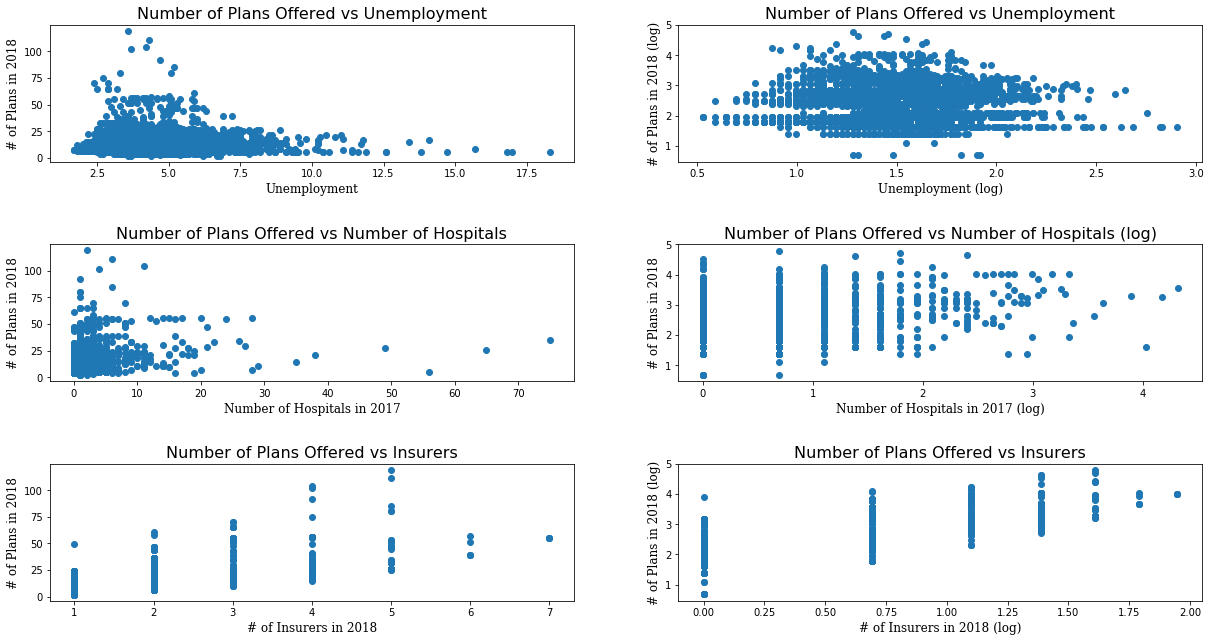

In [37]:
plt.figure(figsize=(20,10))

plt.subplot(321)
_ = plt.scatter(x = plans_data['Unemployment'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("Unemployment",fontdict=font)
_ = plt.title("Number of Plans Offered vs Unemployment", fontsize=16)

plt.subplot(322)
_ = plt.scatter(x = np.log(plans_data['Unemployment']), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018 (log)",fontdict=font)
_ = plt.xlabel("Unemployment (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Unemployment", fontsize=16)

plt.subplot(323)
_ = plt.scatter(x = plans_data['Num_Hosp2017'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("Number of Hospitals in 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Number of Hospitals", fontsize=16)

plt.subplot(324)
_ = plt.scatter(x = np.log(plans_data['Num_Hosp2017']), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("Number of Hospitals in 2017 (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Number of Hospitals (log)", fontsize=16)

plt.subplot(325)
_ = plt.scatter(x = plans_data['count_issuers'], y = plans_data['count_plans'])
_ = plt.ylabel("# of Plans in 2018",fontdict=font)
_ = plt.xlabel("# of Insurers in 2018",fontdict=font)
_ = plt.title("Number of Plans Offered vs Insurers", fontsize=16)

plt.subplot(326)
_ = plt.scatter(x = np.log(plans_data['count_issuers']), y = np.log(plans_data['count_plans']))
_ = plt.ylabel("# of Plans in 2018 (log)",fontdict=font)
_ = plt.xlabel("# of Insurers in 2018 (log)",fontdict=font)
_ = plt.title("Number of Plans Offered vs Insurers", fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9 , hspace=.6)

After a first glance at the plans offered in the Individual Health Insurance Market under the Federal government we observe that there is high variability in the options an individual will face depending on where they live. In some areas of the U.S. there are little options, while in others the options can go high. Higher populated areas tend to have more options. However, when looking at the number of insurance companies present in each area, the number is surprisingly low. 

2718
                     count_plans  count_issuers  Num_Hosp2017   Pop2017  \
count_plans             1.000000       0.668421      0.213821  0.252852   
count_issuers           0.668421       1.000000      0.214164  0.234401   
Num_Hosp2017            0.213821       0.214164      1.000000  0.921183   
Pop2017                 0.252852       0.234401      0.921183  1.000000   
MedIncome2017           0.129539       0.143034      0.171212  0.243056   
IndMarketEnroll2017     0.270887       0.202967      0.731237  0.845268   
Unemployment           -0.034369       0.019240     -0.052905 -0.049248   

                     MedIncome2017  IndMarketEnroll2017  Unemployment  
count_plans               0.129539             0.270887     -0.034369  
count_issuers             0.143034             0.202967      0.019240  
Num_Hosp2017              0.171212             0.731237     -0.052905  
Pop2017                   0.243056             0.845268     -0.049248  
MedIncome2017             1.000000

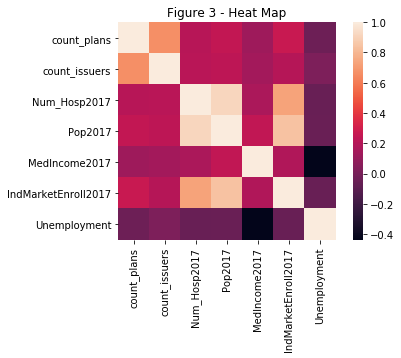

In [14]:
# Compute correlation between continous variables (all continous features and target variable)
varsel = plans_ahrf[['count_plans','count_issuers','Num_Hosp2017','Pop2017','MedIncome2017','IndMarketEnroll2017','Unemployment']][plans_ahrf['Unemployment'].notnull()]
print(len(varsel))
print(varsel.corr())
sns.heatmap(varsel.corr(),square=True)
plt.title("Figure 3 - Heat Map")
plt.savefig("Data description-figure 3.png")